In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

Read in data.

In [2]:
ori_DNA_rep1 = pd.read_csv('../data/counts_20230704/STARR_DNA_rep1_counts.txt', sep='\t', names=['sequence', 'count'])
ori_DNA_rep2 = pd.read_csv('../data/counts_20230704/STARR_DNA_rep2_counts.txt', sep='\t', names=['sequence', 'count'])
ori_RNA_rep1 = pd.read_csv('../data/counts_20230704/STARR_RNA_rep1_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])
ori_RNA_rep2 = pd.read_csv('../data/counts_20230704/STARR_RNA_rep2_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])

Join RNA and DNA on sequences. Only sequences found in all four samples will be retained.

In [3]:
joined_DNA = ori_DNA_rep1.merge(ori_DNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_RNA = ori_RNA_rep1.merge(ori_RNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_counts = joined_DNA.merge(joined_RNA, on='sequence', how='inner', suffixes=('_DNA', '_RNA'))

Calculate normalized DNA counts, then normalize RNA counts by normalized DNA abundance.

In [4]:
joined_counts['cpm_DNA_1'] = (joined_counts['count_rep1_DNA']/joined_counts['count_rep1_DNA'].sum()) * 1e6
joined_counts['cpm_DNA_2'] = (joined_counts['count_rep2_DNA']/joined_counts['count_rep2_DNA'].sum()) * 1e6
joined_counts['log10_RNA_rep1_norm'] = np.log10((joined_counts['collapsed_count_rep1'] + 1) / joined_counts['cpm_DNA_1'])
joined_counts['log10_RNA_rep2_norm'] = np.log10((joined_counts['collapsed_count_rep2'] + 1) / joined_counts['cpm_DNA_2'])
joined_counts.head()

,sequence,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,log10_RNA_rep1_norm,log10_RNA_rep2_norm
0,GGTGTCGTGGTCGGTACAGGACTGTAAGGGTTGCGGTACTTCAGTG...,445,1012,1846,131,1011,82,27.385596,38.554655,0.683052,0.333001
1,AATGTTTTAGGCCAGTGCCATGGGGTATGAAGTGAGGGGAATTGGG...,424,614,4147,268,1982,167,26.093242,23.391856,1.013224,0.856245
2,GTGGCACGTGTGTGATGGGGTACATTAGTCACTTGAGGCCTGAAGA...,423,706,536,52,1701,150,26.031702,26.896824,0.308773,0.749276
3,AGGGGGTGGTACACTGTTTTAAGAAGCCCTGGGCAATTGTCTGACT...,422,791,2502,202,809,79,25.970161,30.135110,0.893021,0.424017
4,ATGTTCCACAGGATGTGGGTGCTGGGTGGTTCAGTTTGAGGCGATG...,416,822,1671,122,1967,142,25.600917,31.316132,0.681650,0.659568


In [5]:
joined_counts.describe()

,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,log10_RNA_rep1_norm,log10_RNA_rep2_norm
count,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000
mean,45.283563,73.148678,321.637133,26.572168,308.532632,26.698141,2.786781,2.786781,0.831593,0.926376
std,29.102870,48.418631,367.016176,27.046461,293.017864,23.188531,1.791010,1.844628,0.550546,0.392673
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.061541,0.038097,-0.936839,-0.890526
25%,25.000000,40.000000,17.000000,4.000000,113.000000,10.000000,1.538517,1.523899,0.418446,0.705070
50%,40.000000,63.000000,255.000000,21.000000,235.000000,21.000000,2.461627,2.400142,0.919353,0.969135
75%,59.000000,94.000000,465.000000,38.000000,431.000000,37.000000,3.630899,3.581164,1.232740,1.188655
max,445.000000,1012.000000,7680.000000,492.000000,10461.000000,649.000000,27.385596,38.554655,3.321428,3.118074


In [6]:
joined_counts['length'] = joined_counts['sequence'].str.len()

Filter out sequences with low RNA counts.

In [7]:
RNA_threshold = 20
DNA_threshold = 20
joined_counts_filtered = joined_counts.loc[(joined_counts['collapsed_count_rep1'] > RNA_threshold)
                                   & (joined_counts['collapsed_count_rep2'] > RNA_threshold)
                                   & (joined_counts['count_rep1_DNA'] > DNA_threshold)
                                   & (joined_counts['count_rep2_DNA'] > DNA_threshold)]
len(joined_counts_filtered)

94790

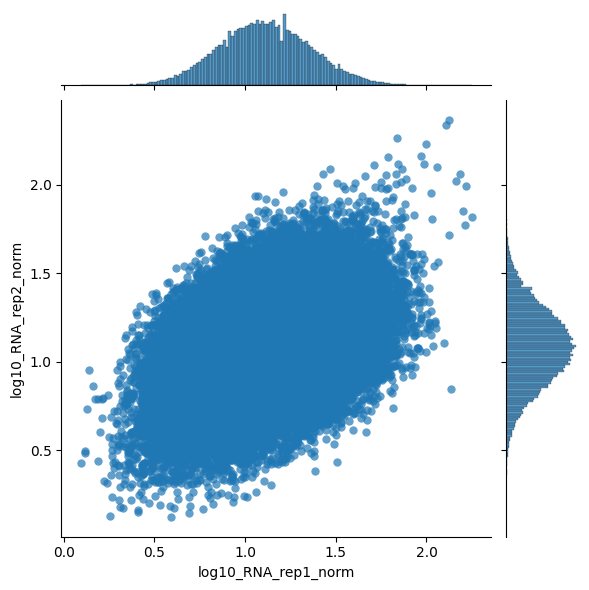

In [8]:
sns.jointplot(data=joined_counts_filtered, x='log10_RNA_rep1_norm', y='log10_RNA_rep2_norm', linewidth=0, alpha=0.7)

Look at correlation with and without DNA normalization.

With DNA normalization:

In [9]:
stats.pearsonr(joined_counts_filtered['log10_RNA_rep1_norm'], joined_counts_filtered['log10_RNA_rep2_norm'])

PearsonRResult(statistic=0.3914868874426565, pvalue=0.0)

Without DNA normalization:

In [10]:
stats.pearsonr(np.log10(joined_counts_filtered['collapsed_count_rep1']), np.log10(joined_counts_filtered['collapsed_count_rep2']))

PearsonRResult(statistic=0.2295591433356925, pvalue=0.0)

Filter for just 100 bp length sequences.

In [11]:
joined_counts_filtered_100bp = joined_counts_filtered[joined_counts_filtered['length'] == 100].reset_index(drop=True)
len(joined_counts_filtered_100bp)

70059

Save filtered sequences and expression values.

In [12]:
rep1_df = joined_counts_filtered_100bp[['sequence', 'log10_RNA_rep1_norm']]
rep2_df = joined_counts_filtered_100bp[['sequence', 'log10_RNA_rep2_norm']]
rep1_df.to_csv("../data/linear_models_20230815/rep1_expression_DNA_20_RNA_20_20230815.csv")
rep2_df.to_csv("../data/linear_models_20230815/rep2_expression_DNA_20_RNA_20_20230815.csv")

Save sequences to fasta file.

In [13]:
def save_to_fasta(df, f):
    for i, row in df.iterrows():
        f.write(f">{i}\n{row['sequence']}\n")

with open("../data/linear_models_20230815/rep1_seqs_DNA_20_RNA_20_20230815.fasta", 'wt') as f:
    save_to_fasta(rep1_df, f)
with open("../data/linear_models_20230815/rep2_seqs_DNA_20_RNA_20_20230815.fasta", 'wt') as f:
    save_to_fasta(rep2_df, f)

Save sequences to tab separated text file.

In [14]:
rep1_df_seq_only = joined_counts_filtered_100bp[['sequence']]
rep2_df_seq_only = joined_counts_filtered_100bp[['sequence']]
rep1_df_seq_only.to_csv("../data/linear_models_20230815/rep1_seqs_DNA_20_RNA_20_20230815.txt", sep='\t', header=False)
rep2_df_seq_only.to_csv("../data/linear_models_20230815/rep2_seqs_DNA_20_RNA_20_20230815.txt", sep='\t', header=False)